In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


In [3]:
import os
import json
import h5py
import flammkuchen as fl

import numpy as np
import pandas as pd

from pathlib import Path
import glob

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

In [4]:
def are_points_in_circle(points, a, b, r):
    # calculate the distance from each point to the center of the circle
    distances = (points[:, 0] - a)**2 + (points[:, 1] - b)**2

    # check if the distances are less than or equal to the square of the radius
    return distances <= r**2

def resample(df, df2):
    #df gets resampled to df2
    df1 =df.copy()
    resampled_df = pd.DataFrame(np.zeros((df2.shape[0], df1.shape[1])), columns=df1.columns)

    for i in df1.columns:
        interpolated_data = np.interp(df2.t, df1.t, df1[i])
        resampled_df[i] = interpolated_data

    return resampled_df

    This notebook reads in the orignal DeepLabCut file and applies 3 filters:

    (1) Edge filter for Arenas to exclude bouts at the edge 
    (2) DeepLabCut filter to just use well tracked frames for analysis

    Lastly it appends motor position to the dataframe.

## Read in Data

In [5]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [6]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_path.name 
# exp_name = Path(fish_path).parts[-2] 
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

#### Read in Original DLC data

In [7]:
filename = list(fish_path.glob('*316000.h5*'))[0]
print (filename)
df_dlc= pd.read_hdf(filename,  header=[1, 2], index_col=0)
df_dlc = df_dlc['DLC_resnet50_dlc_2Dec12shuffle1_316000']

\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata\Raw_Data\240423_f0\111814_videoDLC_resnet50_dlc_2Dec12shuffle1_316000.h5


In [8]:
df_dlc.head()

bodyparts left_eye_anterior                        left_eye_posterior  \
coords                    x           y likelihood                  x   
0                653.235962  549.867249   0.999891         647.881470   
1                654.368347  548.662109   0.999896         649.363464   
2                658.328735  546.076904   0.999923         653.924377   
3                662.999084  541.763550   0.999913         658.501892   
4                665.398071  538.954529   0.999740         661.073425   

bodyparts                        right_eye_anterior                         \
coords              y likelihood                  x           y likelihood   
0          519.701050   0.999758         626.027283  562.335266   0.999914   
1          518.040771   0.999851         626.644653  560.156250   0.999881   
2          515.740967   0.999905         629.848755  558.438354   0.999691   
3          511.638153   0.999953         635.091492  554.000916   0.999719   
4          508.786987   0.999960         638.392883  551.076233   0.999846   

bodyparts right_eye_posterior  ...     tail_1      tail_2              \
coords                      x  ... likelihood           x           y   
0                  602.901550  ...   0.980895  550.919128  328.616638   
1                  603.670349  ...   0.979551  553.069946  323.318237   
2                  607.012573  ...   0.978947  554.070068  322.324982   
3                  612.348083  ...   0.985706  552.845642  316.216949   
4                  615.801147  ...   0.982587  548.529724  316.224487   

bodyparts                 tail_3                             tail_4  \
coords    likelihood           x           y likelihood           x   
0           0.962139  505.450104  277.608337   0.923167  439.471039   
1           0.921706  515.273926  267.767639   0.920416  444.348114   
2           0.863583  524.936035  261.235168   0.891188  461.540009   
3           0.945818  530.994629  256.552765   0.936800  476.081390   
4           0.965356  528.076477  252.677872   0.929202  485.563690   

bodyparts                         
coords              y likelihood  
0          239.365433   0.970800  
1          245.641525   0.980387  
2          236.261642   0.980165  
3          216.947006   0.973007  
4          199.774689   0.969979  

[5 rows x 42 columns]

#### Resample motor log to camera frame rate 

In [9]:
motor_path = list(fish_path.glob('*motor_log.hdf5*'))[0]
motor_path

WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0/111814_motor_log.hdf5')

In [10]:
motor_log = pd.read_hdf(motor_path)

In [11]:
tp_vid = np.linspace(motor_log.t.iloc[0], motor_log.t.iloc[-1], df_dlc.shape[0])
df_dlc = df_dlc.copy()
df_dlc['t'] = tp_vid  

In [12]:
resampled = resample(motor_log, df_dlc)
print (resampled.shape, motor_log.shape, df_dlc.shape)

(95423, 8) (111024, 8) (95423, 43)


##  (1) Add edge filter to DLC dataframe

### Round arena

In [15]:
mask  = fl.load(out_path /'{}_mask.csv'.format(exp_name))
print (mask)

#for round marks
margin = mask[-1]
center_x = mask[0]
center_y = mask[1]
radius = mask[2] 

[2.5, 0, 30, 1]


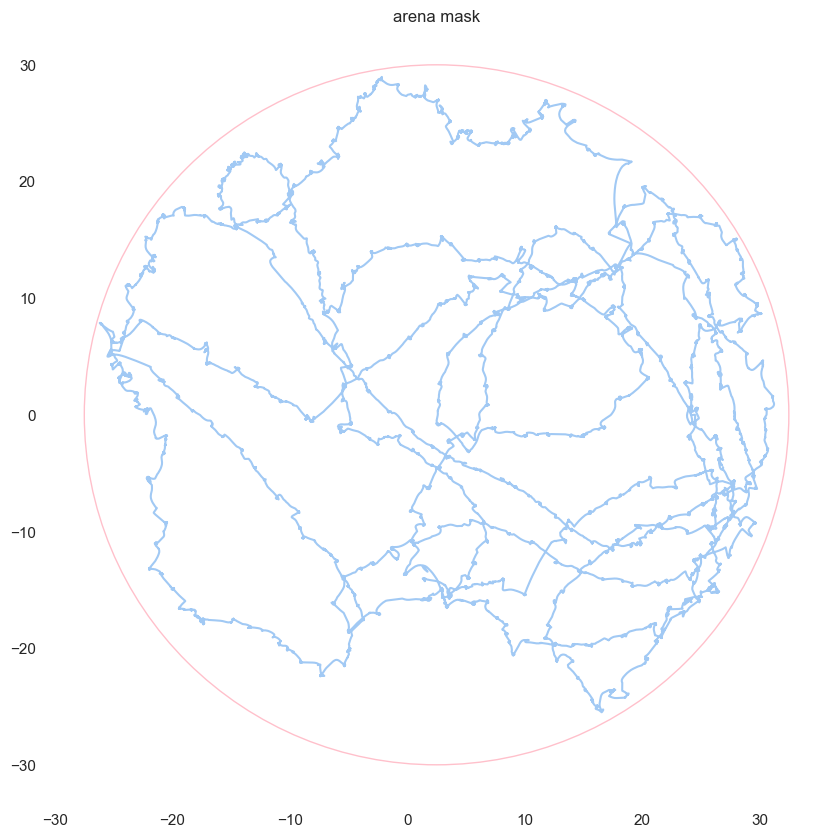

In [16]:
sns.set_theme(style="white", palette="pastel")
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(resampled.x, resampled.y, label='original')

circle = plt.Circle((center_x, center_y), radius, color='pink', fill=False)
ax.add_patch(circle)

plt.title('arena mask')
sns.despine(top=True, right=True, left=True, bottom=True)

plt.savefig(out_path/'plots'/'{}_arena_mask.png'.format(fish_id))

In [17]:
points = np.column_stack((resampled.x,resampled.y))
to_fill = are_points_in_circle(points, center_x, center_y, radius)


In [18]:
df_dlc.insert(0, ("edge_filter", "ok"), to_fill)

### Insert data motor data

In [19]:
#Extract angles
motor_x = resampled.x.values.astype('float')
motor_y = resampled.y.values.astype('float')
motor_z = resampled.z.values.astype('float')
motor_x.shape, motor_y.shape, df_dlc.shape

((95423,), (95423,), (95423, 44))

In [20]:
df_dlc.insert(0, ("motor", "x"), motor_x.T)
df_dlc.insert(0, ("motor", "y"), motor_y.T)
df_dlc.insert(0, ("motor", "z"), motor_z.T)

## (2) Apply Deeplabcut Filter to data

In [21]:
thresh = 0.99

In [22]:
df_orig = df_dlc.copy()
df_tmp = df_dlc.copy()
percentile = df_dlc[df_dlc.body.likelihood >=thresh].shape[0]/df_orig.shape[0]
print ('right now we keep {} % of data'.format(np.round(percentile*100, 3)))

right now we keep 99.794 % of data


In [23]:
good_dlc_tracking = df_dlc[df_dlc.body.likelihood >=thresh].index.values
good_dlc_tracking

array([    0,     1,     2, ..., 95420, 95421, 95422], dtype=int64)

In [24]:
to_fill = np.full(df_tmp.shape[0],-1)
to_fill[good_dlc_tracking] = 1
to_fill

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
df_tmp.insert(0, ("DLC_filter", "pos"), to_fill)

### Save new DLC

In [26]:
out_path_dlc = Path(out_path/ '{}_DLC.csv'.format(fish_id)) 
out_path_dlc

WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/Processed_Data/240423_f0_DLC.csv')

In [27]:
df_tmp.to_csv(out_path_dlc)

In [28]:
df_tmp

bodyparts DLC_filter     motor                      edge_filter  \
coords           pos         z          y         x          ok   
0                  1  0.000000   8.993996 -7.050400        True   
1                  1 -0.000137   9.084572 -7.089576        True   
2                  1  0.000000   9.179195 -7.108448        True   
3                  1  0.000000   9.258852 -7.098520        True   
4                  1 -0.000013   9.320093 -7.081586        True   
...              ...       ...        ...       ...         ...   
95418              1 -0.000008 -14.071809  1.439044        True   
95419              1 -0.000007 -14.078636  1.439372        True   
95420              1 -0.000030 -14.090004  1.441478        True   
95421              1 -0.000061 -14.091182  1.449288        True   
95422              1 -0.000062 -14.079349  1.454791        True   

bodyparts left_eye_anterior                        left_eye_posterior  \
coords                    x           y likelihood                  x   
0                653.235962  549.867249   0.999891         647.881470   
1                654.368347  548.662109   0.999896         649.363464   
2                658.328735  546.076904   0.999923         653.924377   
3                662.999084  541.763550   0.999913         658.501892   
4                665.398071  538.954529   0.999740         661.073425   
...                     ...         ...        ...                ...   
95418            657.147705  496.601166   0.999910         631.599121   
95419            656.905640  500.566345   0.999921         629.901917   
95420            656.891174  493.824280   0.999766         630.628845   
95421            654.963684  494.837524   0.999649         629.970581   
95422            655.257690  499.025238   0.999884         628.855164   

bodyparts              ...      tail_2                             tail_3  \
coords              y  ...           x           y likelihood           x   
0          519.701050  ...  550.919128  328.616638   0.962139  505.450104   
1          518.040771  ...  553.069946  323.318237   0.921706  515.273926   
2          515.740967  ...  554.070068  322.324982   0.863583  524.936035   
3          511.638153  ...  552.845642  316.216949   0.945818  530.994629   
4          508.786987  ...  548.529724  316.224487   0.965356  528.076477   
...               ...  ...         ...         ...        ...         ...   
95418      480.128876  ...  409.898468  460.453949   0.947792  339.952942   
95419      483.825745  ...  411.091217  464.196686   0.948581  340.129059   
95420      476.978973  ...  409.606689  457.396301   0.951901  339.113281   
95421      478.606720  ...  409.819489  459.074493   0.952734  339.182343   
95422      482.637543  ...  410.313782  463.134460   0.938446  339.174530   

bodyparts                             tail_4                         \
coords              y likelihood           x           y likelihood   
0          277.608337   0.923167  439.471039  239.365433   0.970800   
1          267.767639   0.920416  444.348114  245.641525   0.980387   
2          261.235168   0.891188  461.540009  236.261642   0.980165   
3          256.552765   0.936800  476.081390  216.947006   0.973007   
4          252.677872   0.929202  485.563690  199.774689   0.969979   
...               ...        ...         ...         ...        ...   
95418      448.836517   0.909682  265.793488  437.260010   0.979386   
95419      452.161926   0.934786  265.808929  440.797913   0.942461   
95420      444.314087   0.923945  265.891937  433.667084   0.976055   
95421      447.618530   0.891876  264.427094  435.803558   0.976587   
95422      451.175079   0.938536  262.817810  439.732269   0.962361   

bodyparts           t  
coords                 
0           -0.013963  
1           -0.007675  
2           -0.001387  
3            0.004901  
4            0.011189  
...               ...  
95418      599.979327  
95419      599.985615  
95420      5